In [11]:
net = MainNet()
net = wts_init(net, p1=0)
print(net.state_dict())
net_wts = copy.deepcopy(net.state_dict())
torch.save(net_wts, RES_DIR+'torch_params_before')

OrderedDict([('lin1.weight', 
 0.7006  0.3088  0.4518 -0.0308
 0.3056 -0.6543  0.2527 -0.5047
 0.1586  0.5085 -0.6722 -0.1294
-0.1420 -0.2537 -0.1062 -0.1295
 0.5974 -0.2680  0.4851 -0.2601
-0.1367 -0.2028  0.3418  0.0701
 0.2821 -0.1515 -0.2603  0.6256
-0.0547  0.1976  0.0885  0.4135
 0.2587 -0.0143 -0.4718  0.2407
-0.4742  0.2239 -0.4688 -0.5434
[torch.FloatTensor of size 10x4]
), ('lin1.bias', 
 0.1347
-0.7008
 0.1495
 0.0479
 0.3662
-0.0464
 0.3943
 0.1798
-0.0517
 0.0864
[torch.FloatTensor of size 10]
), ('lin2.weight', 
-0.1554  0.2849 -0.1158 -0.1848 -0.2657  0.2280  0.3899  0.1910 -0.0262  0.2769
 0.0200 -0.4220 -0.6713  0.2685  0.3215 -0.0218 -0.7586  0.4042 -0.2724 -0.4799
 0.6526  0.0630 -0.0107  0.2343 -0.2602  0.3709 -0.2754 -0.0056 -0.4070 -0.2263
-0.1172 -0.0395  0.1858  0.1007 -0.2436 -0.2083  0.1239  0.8906 -0.3306 -0.0860
-0.3348 -0.6369 -0.3194 -0.3923 -0.2195  0.2277 -0.2395  0.1795 -0.0435  0.0782
 0.2766  0.4997 -0.0072  0.1606 -0.0660 -0.2377 -0.1205  0.3635 -0.2

In [1]:
% matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch import autograd
from torch.nn.parameter import Parameter
from IPython import display
from torch.utils.data import Dataset, DataLoader
from sklearn import preprocessing
import math
import copy

# Введем константы из задания
#Для воспроизведения результатов
np.random.seed(11)

#Другие константы
num_neuro_1 = 10
num_neuro_2 = 10
num_neuro_3 = 5

RES_DIR = './PUNKT_4_13/'
DATA_DIR = './CCPP/'
HOME_DIR = './'

lr = 1e-3

In [2]:
def save_wts(net, save_dir, before=False, is_pytorch=False):
    if is_pytorch:
        net_wts = copy.deepcopy(net.state_dict())
        if before:
            torch.save(net_wts, save_dir+'params_before')
        else:
            torch.save(net_wts, save_dir+'params')
    else:
        w1 = pd.DataFrame((net.lin1.W).data.numpy())
        b1 = pd.DataFrame((net.lin1.b).data.numpy())
        w2 = pd.DataFrame((net.lin2.W).data.numpy())
        b2 = pd.DataFrame((net.lin2.b).data.numpy())
        w3 = pd.DataFrame((net.lin3.W).data.numpy())
        b3 = pd.DataFrame((net.lin3.b).data.numpy())
        w4 = pd.DataFrame((net.lin4.W).data.numpy())
        b4 = pd.DataFrame((net.lin4.b).data.numpy())
        if before:
            w1.to_csv(save_dir+'w1_before.csv', index=False)
            w2.to_csv(save_dir+'w2_before.csv', index=False)
            w3.to_csv(save_dir+'w3_before.csv', index=False)
            w4.to_csv(save_dir+'w4_before.csv', index=False)
            b1.to_csv(save_dir+'b1_before.csv', index=False)
            b2.to_csv(save_dir+'b2_before.csv', index=False)
            b3.to_csv(save_dir+'b3_before.csv', index=False)
            b4.to_csv(save_dir+'b4_before.csv', index=False)
        else:
            w1.to_csv(save_dir+'w1_.csv', index=False)
            w2.to_csv(save_dir+'w2_.csv', index=False)
            w3.to_csv(save_dir+'w3_.csv', index=False)
            w4.to_csv(save_dir+'w4_.csv', index=False)
            b1.to_csv(save_dir+'b1_.csv', index=False)
            b2.to_csv(save_dir+'b2_.csv', index=False)
            b3.to_csv(save_dir+'b3_.csv', index=False)
            b4.to_csv(save_dir+'b4_.csv', index=False)

In [3]:
class CCPPDataset(Dataset):
    def __init__(self, data):
        self.data = data
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]


class MainNet(nn.Module):
    def __init__(self):
        super(MainNet, self).__init__()
        self.lin1 = nn.Linear(in_size, num_neuro_1)
        self.lin2 = nn.Linear(num_neuro_1, num_neuro_2)
        self.lin3 = nn.Linear(num_neuro_2, num_neuro_3)
        self.lin4 = nn.Linear(num_neuro_3, 1)
        
    def forward(self, x):
        x = self.lin1(x)
        x = F.tanh(x)
        x = self.lin2(x)
        x = F.tanh(x)
        x = self.lin3(x)
        x = F.tanh(x)
        x = self.lin4(x)
        x = F.tanh(x)
        return x

In [4]:
# xavier_normal
def wts_init(net, p1):
    for m in net.modules():
        if isinstance(m, nn.Linear):
            p2 = math.sqrt(2.0/(m.weight.size(0)+m.weight.size(1)))
            m.weight.data.normal_(p1, p2)
            m.bias.data.normal_(p1, p2)               
    return net

----------

In [5]:
#делим 
learn_data = pd.read_csv(HOME_DIR+'split_data/train_set.csv').values
valid_data = pd.read_csv(HOME_DIR+'split_data/val_set.csv').values
test_data = pd.read_csv(HOME_DIR+'split_data/test_set.csv').values

print('\n', learn_data.shape, len(valid_data), len(test_data))

batch_size = len(learn_data)
in_size = learn_data.shape[1]-1

print(learn_data)


 (5622, 5) 2812 938
[[ 1.33695848  1.00442921 -1.02915794 -0.45464224  0.23549669]
 [ 0.36737594 -0.322275   -0.82578341  0.71944023  0.3210596 ]
 [ 0.51241045  1.47763351 -0.17533555  1.02296332  0.23390728]
 ...
 [-1.52210138 -1.20097049  0.4014767   1.39822822  0.84874172]
 [ 1.19192397  1.0886769  -0.53124098 -0.26494031  0.10357616]
 [ 0.44257902  0.22887809 -0.34189228 -0.61261221  0.28807947]]


In [6]:
dataset = CCPPDataset(learn_data)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

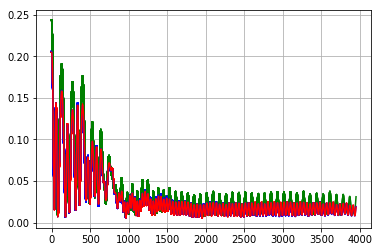

Number train: 1, epoh: 3950
train:  0.018475355580449104
valid:  0.019184688
test:  0.03100355


AttributeError: module 'math' has no attribute 'mean'

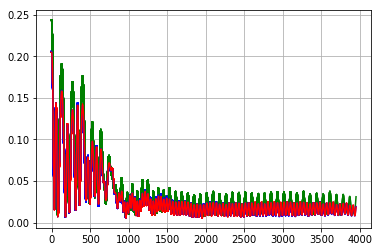

In [12]:
%%time 

name='413a_holdout'
criterion = nn.MSELoss()
num_epoch = 4000
num_train=1

loss_epoh = []
valid_loss_epoh = []
test_loss_epoh = []
    
fig = plt.figure(clear=True)
    
net = MainNet()
net.load_state_dict(torch.load(RES_DIR+'torch_params_before'))
    
for epoh in range(num_epoch):

    if epoh % 50 == 0:
        plt.grid(True)
            
        plt.plot(test_loss_epoh, color='g')
        plt.plot(valid_loss_epoh, color='b')  
        plt.plot(loss_epoh, color='r')    

        display.clear_output(wait=True)
        display.display(plt.gcf())

        print('Number train: {}, epoh: {}'.format(num_train, epoh))
        if epoh > 0:
            print("train: ", loss_epoh[epoh-1])
            print("valid: ", valid_loss_epoh[epoh-1])
            print("test: ", test_loss_epoh[epoh-1])

    loss_acc = 0
    for mini_batch in dataloader:
        learn_inputs = autograd.Variable(mini_batch[:, 0:in_size].float()).unsqueeze(1)
        learn_labels = autograd.Variable(mini_batch[:, in_size].float()).unsqueeze(1)

        learn_output = net(learn_inputs)
        loss = criterion(learn_output, learn_labels)
        loss.backward()
        loss_acc += loss.data[0]

        net.lin1.weight.data -= lr * net.lin1.weight.grad.data
        net.lin1.bias.data -= lr * net.lin1.bias.grad.data
        net.lin2.weight.data -= lr * net.lin2.weight.grad.data
        net.lin2.bias.data -= lr * net.lin2.bias.grad.data
        net.lin3.weight.data -= lr * net.lin3.weight.grad.data
        net.lin3.bias.data -= lr * net.lin3.bias.grad.data
        net.lin4.weight.data -= lr * net.lin4.weight.grad.data
        net.lin4.bias.data -= lr * net.lin4.bias.grad.data

    loss_epoh.append(loss_acc/len(dataloader))
     #print(loss_acc)
    valid_inputs = autograd.Variable(torch.from_numpy(valid_data[:, 0:in_size]).float()).unsqueeze(1)
    valid_labels = autograd.Variable(torch.from_numpy(valid_data[:, in_size]).float()).unsqueeze(1)
    test_inputs = autograd.Variable(torch.from_numpy(test_data[:, 0:in_size]).float()).unsqueeze(1)
    test_labels = autograd.Variable(torch.from_numpy(test_data[:, in_size]).float()).unsqueeze(1)
    valid_output = net(valid_inputs)
    valid_loss = criterion(valid_output, valid_labels).data.numpy()
     #print(np.max(valid_loss))
    test_output = net(test_inputs)
    test_loss = criterion(test_output, test_labels).data.numpy()

    valid_loss_epoh.append(np.mean(valid_loss))
    test_loss_epoh.append(np.mean(test_loss))

print('train: {}+-{}\ntest: {} +-{}'.format(math.mean(loss_10),
          math.std(loss_10), math.mean(test_loss_10), math.std(test_loss_10)))     
plt.savefig(RES_DIR+name+'.png')

In [14]:
print('train: {}+-{}\ntest: {} +-{}'.format(np.mean(loss_epoh),
          np.std(loss_epoh), np.mean(test_loss_epoh), np.std(test_loss_epoh)))

train: 0.029092356689507142+-0.030153058879351487
test: 0.03366313874721527 +-0.03479393571615219


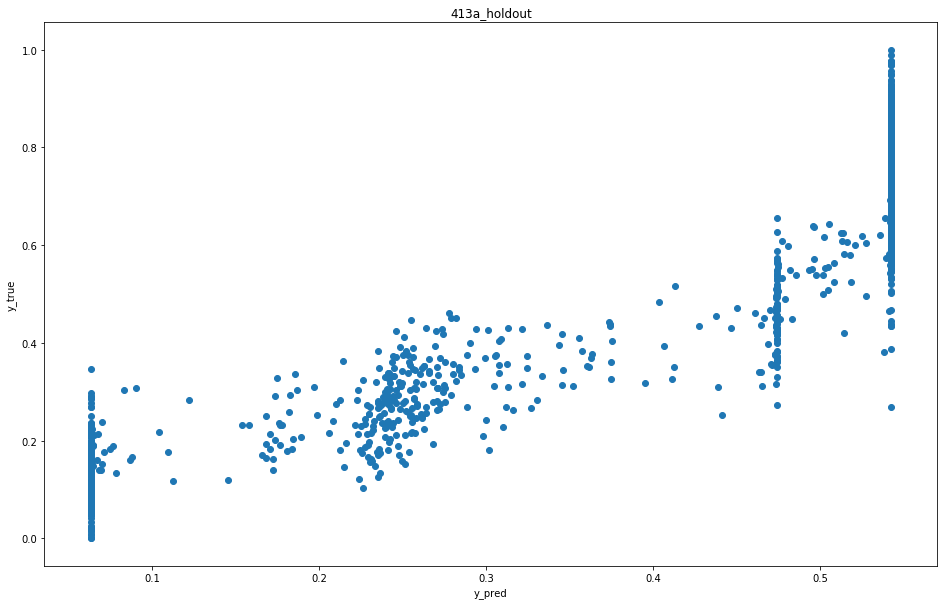

In [15]:
#net = MainPyNet(IN_SIZE, 1)

y_pred = net(autograd.Variable(torch.from_numpy(test_data[:, 0:in_size]).float()).unsqueeze(1))
fig = plt.figure(figsize=(16, 10), clear=True)
plt.scatter(np.sort(y_pred.data.numpy()), test_data[:,in_size])
plt.xlabel('y_pred')
plt.ylabel('y_true')
plt.title(name)
#plt.show()
plt.savefig(RES_DIR+'after_'+name+'.png')

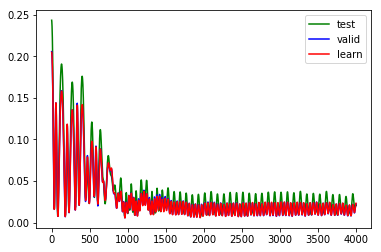

In [16]:
fig = plt.figure()

plt.plot(test_loss_epoh, color='g', label = 'test')
plt.plot(valid_loss_epoh, color='b', label = 'valid')
plt.plot(loss_epoh, color='r', label = 'learn')

plt.legend()
#plt.show()
plt.savefig(RES_DIR+name+'_train_valid_test.png', bbox_inches='tight')

--------------

In [7]:
#делим 
init_data = pd.read_csv(HOME_DIR+'split_data/all_set.csv').values
X = init_data[:, :4]
y = init_data[:, 4]
print(init_data.shape)

in_size = init_data.shape[1]-1

print(init_data[0:5])

(9372, 5)
[[-6.44914572e-01 -9.99395258e-01  1.91486193e+00 -1.06821286e-03
   5.69536424e-01]
 [ 7.30421866e-01  6.70668000e-01  1.20798653e+00 -9.75435062e-01
   3.19337748e-01]
 [-1.97045899e+00 -1.18530796e+00 -1.74191672e-01  1.31076565e+00
   9.04635762e-01]
 [ 1.49066346e-01  2.26368152e-01 -5.10966056e-01  2.38892963e-01
   3.47284768e-01]
 [-1.20204694e+00 -1.33498344e+00 -6.88123415e-01  1.62057143e+00
   7.10463576e-01]]


In [69]:
from sklearn.model_selection import ShuffleSplit
n_splits=5
ss = ShuffleSplit(n_splits=n_splits, test_size=0.3, random_state=21)

net = MainNet()

name='413a_monte-carlo'
criterion = nn.MSELoss()
num_epoch = 1000
num_run = 10

loss_10 = []
test_loss_10 = []

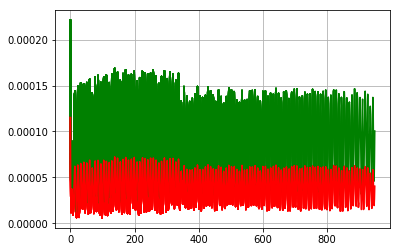

Number train: 9, epoh: 950
train:  4.035309678537417e-05
test:  0.00010051939468703619
train: 3.415442310857813e-05+-1.3114524155151466e-05
test: 8.060975129013125e-05 +-3.0623471238506524e-05
Wall time: 6min 17s


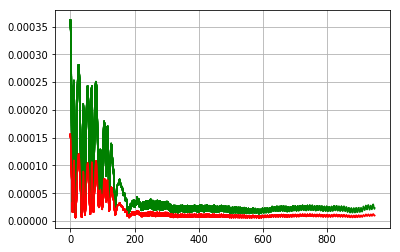

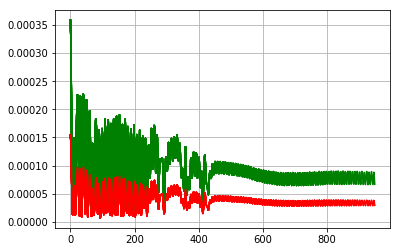

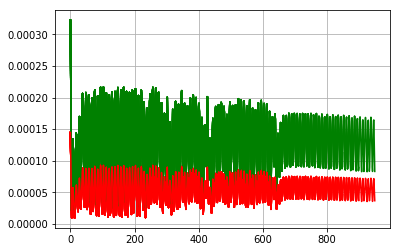

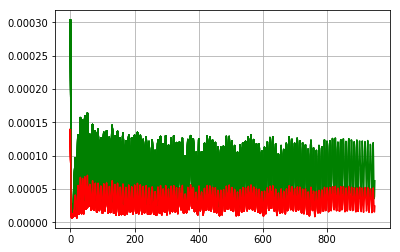

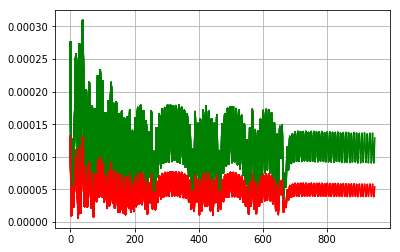

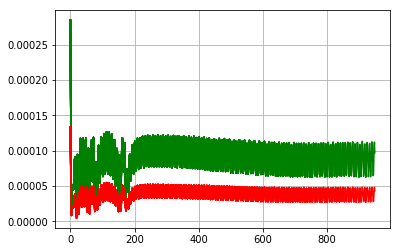

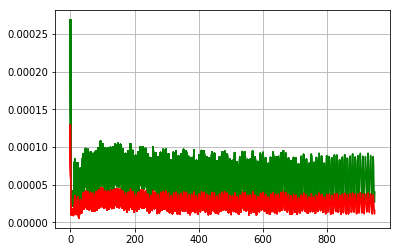

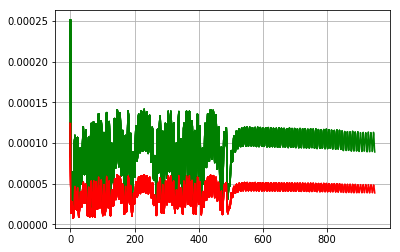

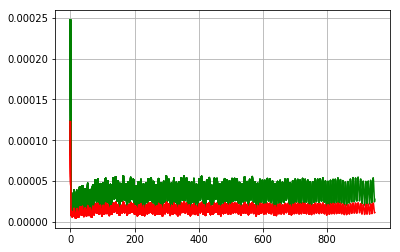

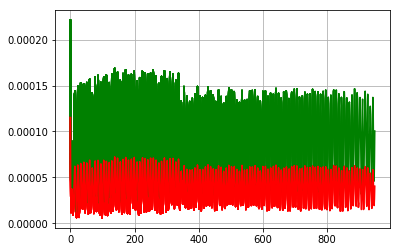

In [70]:
%%time
for num_train in range(num_run):
    loss_epoh = []
    test_loss_epoh = []
    
    fig = plt.figure(clear=True)
    
    net.load_state_dict(torch.load(RES_DIR+'torch_params_before'))
    net = net.double()
    
    for epoh in range(num_epoch):

        if epoh % 50 == 0:
            plt.grid(True)
            
            plt.plot(test_loss_epoh, color='g')
            plt.plot(loss_epoh, color='r')    

            display.clear_output(wait=True)
            display.display(plt.gcf())

            print('Number train: {}, epoh: {}'.format(num_train, epoh))
            if epoh > 0:
                print("train: ", loss_epoh[epoh-1])
                print("test: ", test_loss_epoh[epoh-1])

        loss_train = 0
        loss_test = 0
        len_data = 0
        len_test_data = 0
        #print('===================================')
        for train_index, test_index in ss.split(init_data):
            learn_inputs = autograd.Variable(torch.from_numpy(X[train_index])).unsqueeze(1)
            learn_labels = autograd.Variable(torch.from_numpy(y[train_index])).unsqueeze(1)
            
            learn_output = net(learn_inputs)
            loss = criterion(learn_output, learn_labels)
            loss.backward()
            loss_train += loss.data[0]
            len_data = len(train_index)

            net.lin1.weight.data -= lr * net.lin1.weight.grad.data
            net.lin1.bias.data -= lr * net.lin1.bias.grad.data
            net.lin2.weight.data -= lr * net.lin2.weight.grad.data
            net.lin2.bias.data -= lr * net.lin2.bias.grad.data
            net.lin3.weight.data -= lr * net.lin3.weight.grad.data
            net.lin3.bias.data -= lr * net.lin3.bias.grad.data
            net.lin4.weight.data -= lr * net.lin4.weight.grad.data
            net.lin4.bias.data -= lr * net.lin4.bias.grad.data
            
            test_inputs = autograd.Variable(torch.from_numpy(X[test_index])).unsqueeze(1)
            test_labels = autograd.Variable(torch.from_numpy(y[test_index])).unsqueeze(1)
            test_output = net(test_inputs)
            loss_test += criterion(test_output, test_labels).data[0]
            len_test_data = len(test_index)
            #print(loss_test)
            

        loss_epoh.append(loss_train/len_data)
        test_loss_epoh.append(loss_test/len_test_data)
        
    loss_10.append(loss_epoh[-1])
    test_loss_10.append(test_loss_epoh[-1])

print('train: {}+-{}\ntest: {} +-{}'.format(np.mean(loss_10),
          np.std(loss_10), np.mean(test_loss_10), np.std(test_loss_10)))     

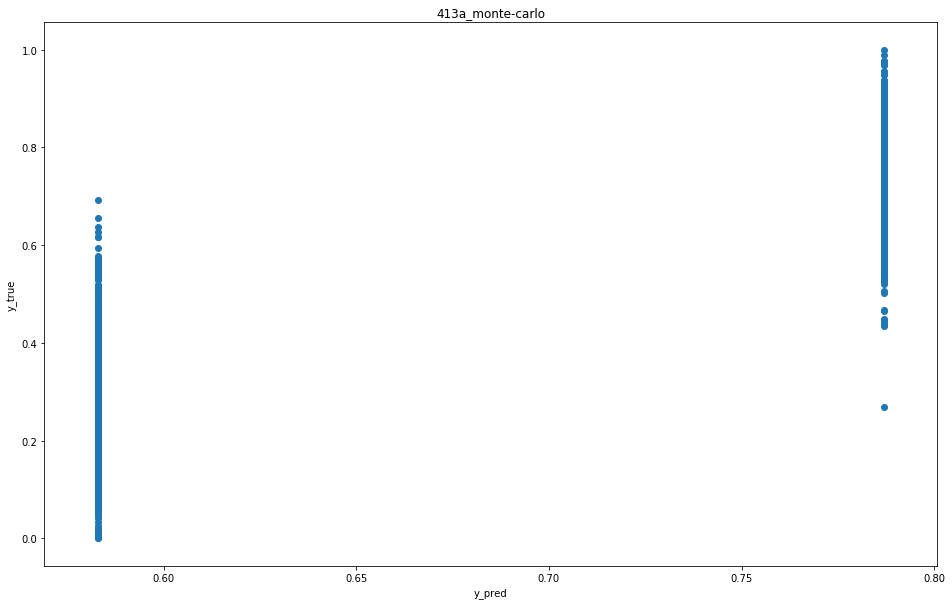

In [71]:
#net = MainPyNet(IN_SIZE, 1)
net=net.float()
y_pred = net(autograd.Variable(torch.from_numpy(test_data[:, 0:4]).float()).unsqueeze(1))
fig = plt.figure(figsize=(16, 10), clear=True)
plt.scatter(np.sort(y_pred.data.numpy()), test_data[:,4])
plt.xlabel('y_pred')
plt.ylabel('y_true')
plt.title(name)
plt.show()

In [ ]:
fig = plt.figure()

plt.plot(test_loss_epoh, color='g', label = 'test')
plt.plot(loss_epoh, color='b', label = 'learn')

plt.legend()
#plt.show()
plt.savefig(RES_DIR+name+'_train_valid_test.png', bbox_inches='tight')

--------------------------

In [9]:
#         0  1   2  3   4   5    6    7    8    9    10
splits = [2, 6, 10, 30, 50, 70, 100, 150, 200, 500, 1000]
dict1 = {x: {'train': [], 'test': []} for x in splits}

In [10]:
from sklearn.model_selection import KFold
n_splits=splits[7]
kf = KFold(n_splits=n_splits)

net = MainNet()

name='413a_k-fold'
criterion = nn.MSELoss()
num_epoch = 500

loss_10 = []
test_loss_10 = []

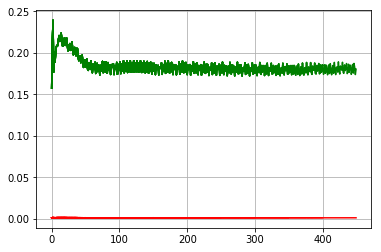

Number train: 9, epoh: 450
train:  0.0012150872727714921
test:  0.18017659761137989
train: 0.0007339758104482574+-0.00040353008719538777
test: 0.11026707251509263 +-0.0606426809926957
Wall time: 1h 46min 11s


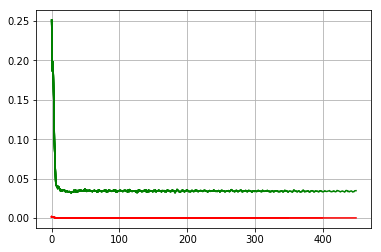

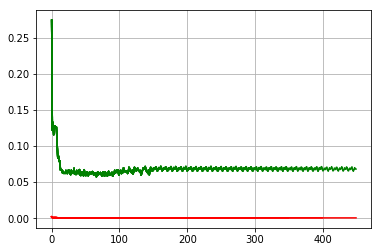

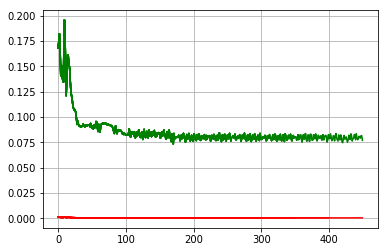

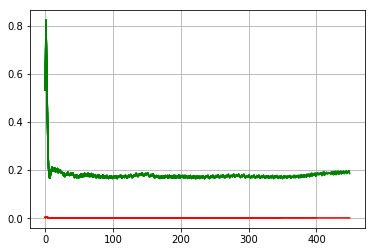

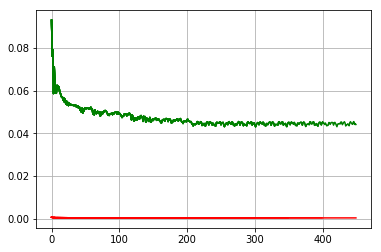

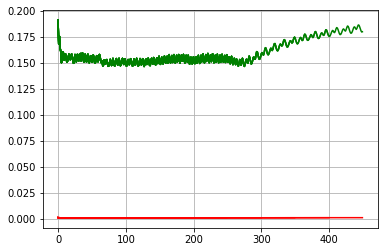

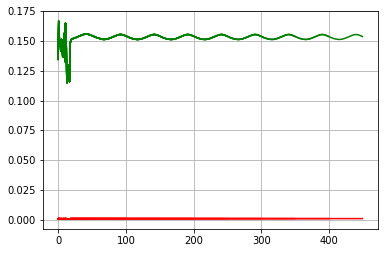

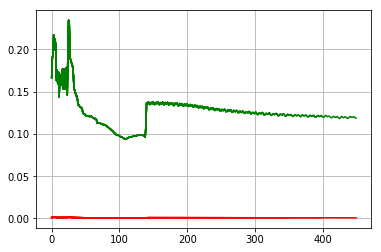

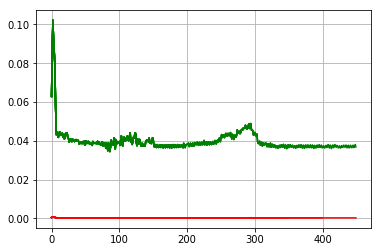

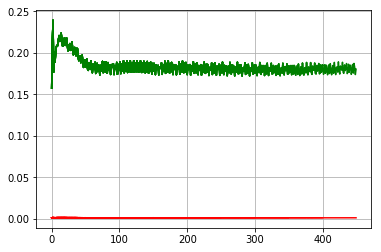

In [11]:
%%time
num_run = 10
for num_train in range(num_run):
    loss_epoh = []
    test_loss_epoh = []
    
    fig = plt.figure(clear=True)

    net.load_state_dict(torch.load(RES_DIR+'torch_params_before'))
    net = net.double()
    
    for epoh in range(num_epoch):

        if epoh % 50 == 0:
            plt.grid(True)
            
            plt.plot(test_loss_epoh, color='g')
            plt.plot(loss_epoh, color='r')    

            display.clear_output(wait=True)
            display.display(plt.gcf())

            print('Number train: {}, epoh: {}'.format(num_train, epoh))
            if epoh > 0:
                print("train: ", loss_epoh[epoh-1])
                print("test: ", test_loss_epoh[epoh-1])

        loss_train = 0
        loss_test = 0
        len_data = 0
        len_test_data = 0
        for train_index, test_index in kf.split(init_data):
            learn_inputs = autograd.Variable(torch.from_numpy(X[train_index])).unsqueeze(1)
            learn_labels = autograd.Variable(torch.from_numpy(y[train_index])).unsqueeze(1)

            learn_output = net(learn_inputs)
            loss = criterion(learn_output, learn_labels)
            loss.backward()
            loss_train += loss.data[0]
            len_data = len(train_index)

            net.lin1.weight.data -= lr * net.lin1.weight.grad.data
            net.lin1.bias.data -= lr * net.lin1.bias.grad.data
            net.lin2.weight.data -= lr * net.lin2.weight.grad.data
            net.lin2.bias.data -= lr * net.lin2.bias.grad.data
            net.lin3.weight.data -= lr * net.lin3.weight.grad.data
            net.lin3.bias.data -= lr * net.lin3.bias.grad.data
            net.lin4.weight.data -= lr * net.lin4.weight.grad.data
            net.lin4.bias.data -= lr * net.lin4.bias.grad.data
            
            test_inputs = autograd.Variable(torch.from_numpy(X[test_index])).unsqueeze(1)
            test_labels = autograd.Variable(torch.from_numpy(y[test_index])).unsqueeze(1)
            test_output = net(test_inputs)
            loss_test += criterion(test_output, test_labels).data[0]
            len_test_data = len(test_index)

        loss_epoh.append(loss_train/len_data)
        test_loss_epoh.append(loss_test/len_test_data)
        
    loss_10.append(loss_epoh[-1])
    test_loss_10.append(test_loss_epoh[-1])

dict1[n_splits]['train'].append(loss_10)
dict1[n_splits]['test'].append(test_loss_10)
print('train: {}+-{}\ntest: {} +-{}'.format(np.mean(loss_10),
          np.std(loss_10), np.mean(test_loss_10), np.std(test_loss_10)))   
#plt.savefig(RES_DIR+name+str(n_splits)+'train_test.png')

In [12]:
dict1

{2: {'test': [], 'train': []},
 6: {'test': [], 'train': []},
 10: {'test': [], 'train': []},
 30: {'test': [], 'train': []},
 50: {'test': [], 'train': []},
 70: {'test': [], 'train': []},
 100: {'test': [], 'train': []},
 150: {'test': [[0.0342015134806168,
    0.07007030948876018,
    0.0838365490111586,
    0.18807852247150325,
    0.04467170857075611,
    0.18410734301166412,
    0.15355526738560504,
    0.12196972564273457,
    0.03742479634566416,
    0.18475498974246346]],
  'train': [[0.00022727139327525608,
    0.0004697320644904763,
    0.000553595974501046,
    0.0012514115021964416,
    0.0002994926411768665,
    0.0012372054395814267,
    0.0010195485736395192,
    0.0008148406057704339,
    0.0002478368178618289,
    0.00121882309198928]]},
 200: {'test': [], 'train': []},
 500: {'test': [], 'train': []},
 1000: {'test': [], 'train': []}}

In [13]:
dict2 = {x: {'train_mean': 0, 'test_mean': 0, 'train_std': 0, 'test_std': 0} for x in splits}

for i in dict1.keys():
    dict2[i]['train_mean']=np.mean(dict1[i]['train'])
    dict2[i]['test_mean']=np.mean(dict1[i]['test'])
    
    dict2[i]['train_std']=np.std(dict1[i]['train'])
    dict2[i]['test_std']=np.std(dict1[i]['test'])

C:\Programs\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Programs\Anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Programs\Anaconda3\lib\site-packages\numpy\core\_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Programs\Anaconda3\lib\site-packages\numpy\core\_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Programs\Anaconda3\lib\site-packages\numpy\core\_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [14]:
df = pd.DataFrame(dict2)
df = df.dropna(axis=1)
df = df.transpose()
df.to_csv(RES_DIR+name+'_150-200.csv', index=False)

---------------------------

In [40]:
df = pd.read_csv(RES_DIR+name+'_2-70.csv')
df2 = pd.read_csv(RES_DIR+name+'_100.csv')
df3 = pd.read_csv(RES_DIR+name+'_150-200.csv')

df.loc[6] = [df2[x][0] for x in df2.keys()]
df.loc[7] = [df3[x][0] for x in df3.keys()]

df

,test_mean,test_std,train_mean,train_std
0,0.000015,0.000013,0.000015,0.000013
1,0.000209,0.000184,0.000041,0.000034
2,0.000613,0.000377,0.000067,0.000041
3,0.003770,0.001417,0.000129,0.000049
4,0.010803,0.005385,0.000221,0.000112
5,0.026345,0.018555,0.000379,0.000267
6,0.035168,0.017450,0.000351,0.000175
7,0.110267,0.060643,0.000734,0.000404


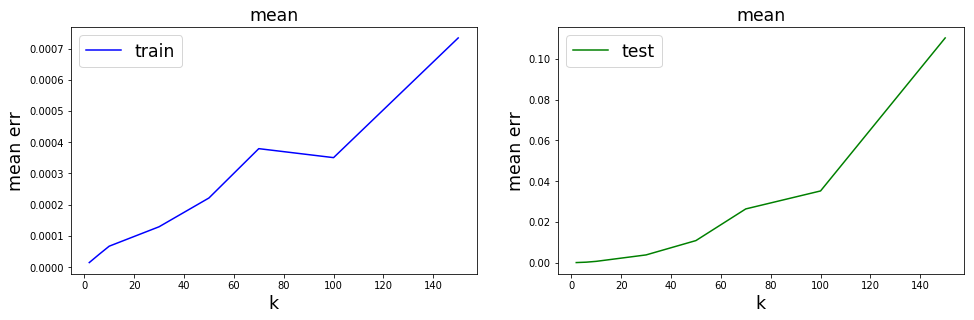

In [46]:
k_list = [2, 6, 10, 30, 50, 70, 100, 150]
fig = plt.figure(figsize=(16, 10), clear=True)
plt.subplot(221)
plt.plot(k_list, df['train_mean'], color='b', label='train')
plt.xlabel('k', fontsize='xx-large')
plt.ylabel('mean err', fontsize='xx-large')
plt.legend(fontsize='xx-large')
plt.title('mean', fontsize='xx-large')

plt.subplot(222)
plt.plot(k_list, df['test_mean'], color='g', label='test')
plt.xlabel('k', fontsize='xx-large')
plt.ylabel('mean err', fontsize='xx-large')
plt.legend(fontsize='xx-large')
plt.title('mean', fontsize='xx-large')

plt.savefig(RES_DIR+'means.png')

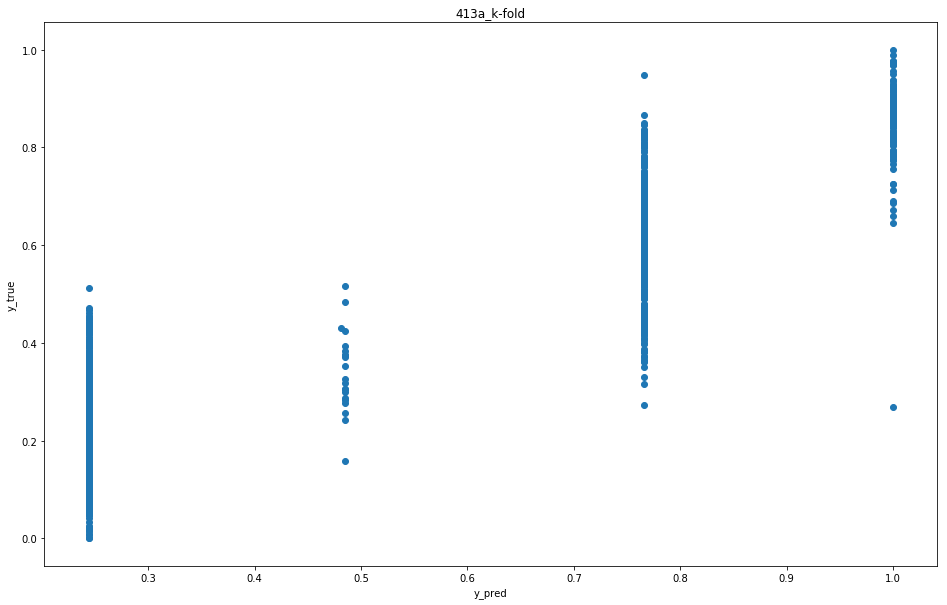

In [66]:
#net = MainPyNet(IN_SIZE, 1)
net=net.float()
y_pred = net(autograd.Variable(torch.from_numpy(test_data[:, 0:4]).float()).unsqueeze(1))
fig = plt.figure(figsize=(16, 10), clear=True)
plt.scatter(np.sort(y_pred.data.numpy()), test_data[:,4])
plt.xlabel('y_pred')
plt.ylabel('y_true')
plt.title(name)
#plt.show()
plt.savefig(RES_DIR+'after_'+str(n_splits)+name+'.png')

In [ ]:
fig = plt.figure()

plt.plot(test_loss_epoh, color='g', label = 'test')
plt.plot(loss_epoh, color='b', label = 'learn')

plt.legend()
#plt.show()
plt.savefig(RES_DIR+name+'_train_valid_test.png', bbox_inches='tight')

--------------------

In [74]:
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()
loo.get_n_splits(X)

net = MainNet()

name='413a_loocv'
criterion = nn.MSELoss()
num_epoch = 4000
num_run = 10

loss_10 = []
test_loss_10 = []

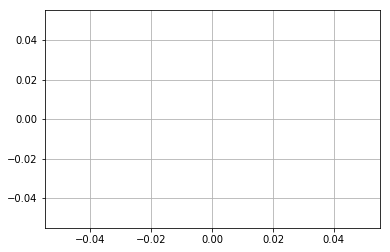

Number train: 0, epoh: 0


KeyboardInterrupt: 

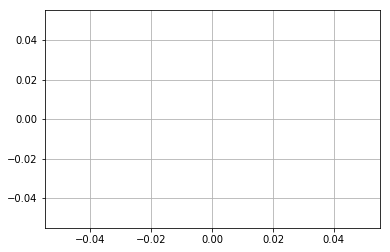

In [75]:
%%time
for num_train in range(num_run):
    loss_epoh = []
    test_loss_epoh = []
    
    fig = plt.figure(clear=True)
    
    net.load_state_dict(torch.load(RES_DIR+'torch_params_before'))
    net = net.double()
    
    for epoh in range(num_epoch):

        if epoh % 50 == 0:
            plt.grid(True)
            
            plt.plot(test_loss_epoh, color='g')
            plt.plot(loss_epoh, color='r')    

            display.clear_output(wait=True)
            display.display(plt.gcf())

            print('Number train: {}, epoh: {}'.format(num_train, epoh))
            if epoh > 0:
                print("train: ", loss_epoh[epoh-1])
                print("test: ", test_loss_epoh[epoh-1])

        loss_train = 0
        loss_test = 0
        len_data = 0
        len_test_data = 0
        for train_index, test_index in loo.split(init_data):
            learn_inputs = autograd.Variable(torch.from_numpy(X[train_index])).unsqueeze(1)
            learn_labels = autograd.Variable(torch.from_numpy(y[train_index])).unsqueeze(1)

            learn_output = net(learn_inputs)
            loss = criterion(learn_output, learn_labels)
            loss.backward()
            loss_train += loss.data[0]
            len_data = len(train_index)

            net.lin1.weight.data -= lr * net.lin1.weight.grad.data
            net.lin1.bias.data -= lr * net.lin1.bias.grad.data
            net.lin2.weight.data -= lr * net.lin2.weight.grad.data
            net.lin2.bias.data -= lr * net.lin2.bias.grad.data
            net.lin3.weight.data -= lr * net.lin3.weight.grad.data
            net.lin3.bias.data -= lr * net.lin3.bias.grad.data
            net.lin4.weight.data -= lr * net.lin4.weight.grad.data
            net.lin4.bias.data -= lr * net.lin4.bias.grad.data
            
            test_inputs = autograd.Variable(torch.from_numpy(X[test_index])).unsqueeze(1)
            test_labels = autograd.Variable(torch.from_numpy(y[test_index])).unsqueeze(1)
            test_output = net(test_inputs)
            test_loss += criterion(test_output, test_labels).data[0]
            len_test_data = len(test_index)
            

        loss_epoh.append(loss_train/len_data)
        test_loss_epoh.append(test_loss/len_test_data)
        
    loss_10.append(loss_epoh[-1])
    test_loss_10.append(test_loss_epoh[-1])

print('train: {}+-{}\ntest: {} +-{}'.format(np.mean(loss_10),
          np.std(loss_10), np.mean(test_loss_10), np.std(test_loss_10)))         

In [ ]:
#net = MainPyNet(IN_SIZE, 1)

y_pred = net(autograd.Variable(torch.from_numpy(test_data[:, 0:4]).float()).unsqueeze(1))
fig = plt.figure(figsize=(16, 10), clear=True)
plt.scatter(np.sort(y_pred.data.numpy()), test_data[:,4])
plt.xlabel('y_pred')
plt.ylabel('y_true')
plt.title(name)
#plt.show()
plt.savefig(RES_DIR+'after_'+name+'.png')

In [ ]:
fig = plt.figure()

plt.plot(test_loss_epoh, color='g', label = 'test')
plt.plot(loss_epoh, color='b', label = 'learn')

plt.legend()
#plt.show()
plt.savefig(RES_DIR+name+'_train_valid_test.png', bbox_inches='tight')

-----------------